# Vehicle Detection
## Linear SVM Approach
----

*Created vehicle detection pipeline with Support Vector Machines (OpenCV + HOG)*.

### Steps:

+ Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
+ A color transform is applied to the image and append binned color features, as well as histograms of color, to HOG feature vector.
+ Normalize your features and randomize a selection for training and testing.
+ Implement a sliding-window technique and use SVM classifier to search for vehicles in images.
+ Run pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
+ Estimate a bounding box for detected vehicles.

### Datasets:

Here are links to the labeled data for [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) examples to train your classifier. These example images come from a combination of the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), [KITTI vision benchmark suite](http://www.gti.ssr.upm.es/data/Vehicle_database.html), and examples extracted from the project video itself. You are welcome and encouraged to take advantage of the recently released [Udacity labeled dataset](https://github.com/udacity/self-driving-car/tree/master/annotations) to augment your training data.

## Step 0: SETUP

In [1]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time
import os
import random
%matplotlib inline

# Where to save the figures
PROJECT_ROOT_DIR = "."
FOLDER_ID = "figures"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", FOLDER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Step 1: Dataset Summary & Exploration

*Load the dataset*

In [2]:
# Read in vehicles and non-vehicels.
vehicle_image_names = glob.glob('dataset/vehicles/**/*.png')
non_vehicle_image_names = glob.glob('dataset/non-vehicles/**/*.png')

vehicle_images = [mpimg.imread(vehicle_image_name) for vehicle_image_name in vehicle_image_names]
non_vehicle_images = [mpimg.imread(non_vehicle_image_name) for non_vehicle_image_name in non_vehicle_image_names]

*Show the number of images in two datasets, in addition to the image size.*

In [3]:
print("Number of vehicles:",len(vehicle_images))
print("Number of non-vehicles:", len(non_vehicle_images))
print("Image data shape:", vehicle_images[0].shape)

Number of vehicles: 8792
Number of non-vehicles: 8968
Image data shape: (64, 64, 3)


*Plot sample images randomly.*

In [4]:
def list_images(dataset, name_figure, cmap=None):
    """
    Display a list of images in a single figure with matplotlib.
    """
    plt.figure(figsize=(15, 6))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        indx = random.randint(0, len(dataset)-1)
        
        # Use gray scale colormap if there is only one channel.
        cmap = 'gray' if len(dataset[indx].shape) == 2 else cmap
        plt.imshow(dataset[indx], cmap=cmap)
        plt.xticks([]), plt.yticks([])
        plt.title(name_figure)
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    save_fig(name_figure)
    plt.show()

Saving figure vehicle sample


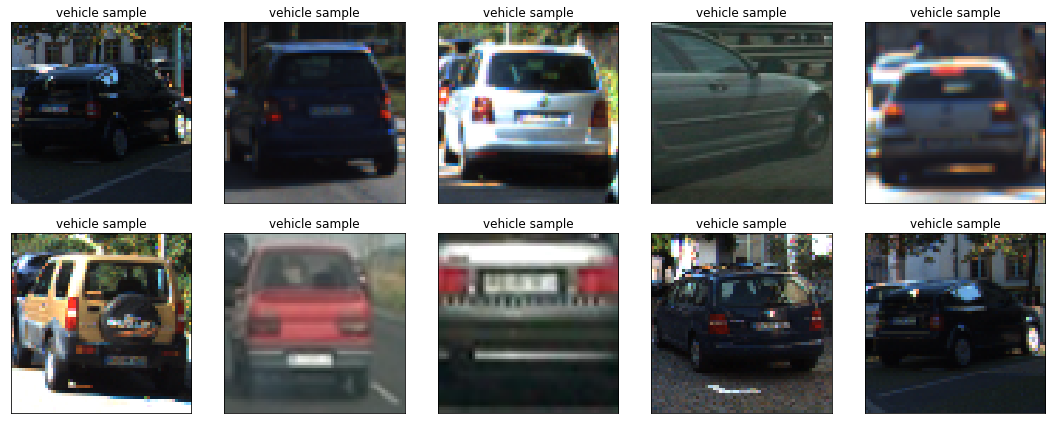

Saving figure non-vehicle sample


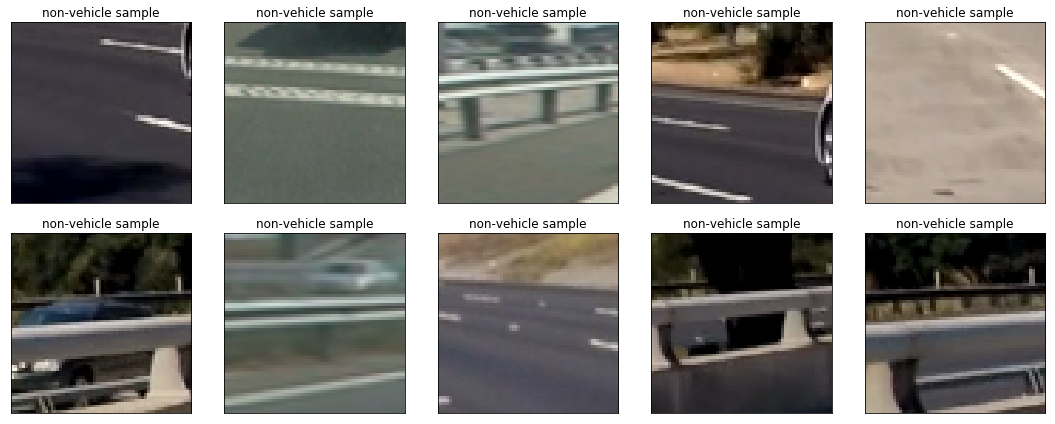

In [5]:
# Plotting sample examples
list_images(vehicle_images, "vehicle sample")
list_images(non_vehicle_images, "non-vehicle sample")

## Step 2: Extract Features

### Step 2.1: Color Spaces

In [6]:
### Extract Color Space.

# Creating a Histogram.
def color_hist(image, nbins=32, bins_range=(0,255), resize=None, color_feats=False):
    """Compute the histogram of the color channels seperately."""
    if(resize != None):
        image= cv2.resize(image, resize)
    # Compute the histogram of the color channels separately.
    channel1_hist = np.histogram(image[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(image[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(image[:, :, 2], bins=nbins, range=bins_range)
    
    if color_feats == False:
        # Concatenate the histograms into a single feature vector.
        return np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    else:
        return channel1_hist, channel2_hist, channel3_hist
    
# Find Center of the bin edges
def bin_center(histogram_channel):
    bin_edges = histogram_channel[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    return bin_centers

*Checking Color Features for Vehicles.*

Saving figure color_features_for_vehicle
Number of features of vehicle image: 96


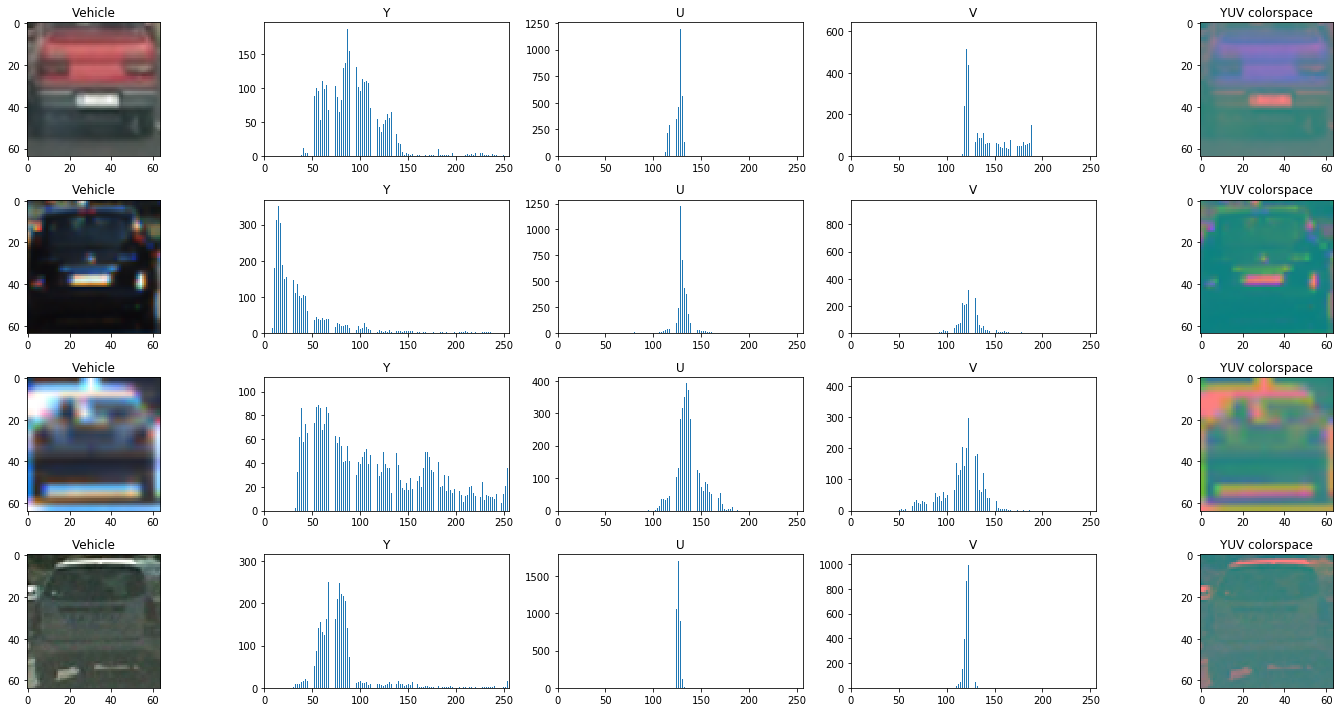

In [7]:
f, axes= plt.subplots(4,5, figsize=(20,10))
f.subplots_adjust(hspace=0.5)

for index in range(4):
        
    indx = random.randint(0, len(vehicle_image_names)-1)
    img = cv2.imread(vehicle_image_names[indx])
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    colored_image= cv2.cvtColor(rgb_img,cv2.COLOR_RGB2YUV)
    r,g,b = color_hist(colored_image, 128, color_feats=True)
   
    center= bin_center(r)
    axes[index,0].imshow(rgb_img)
    axes[index,0].set_title("Vehicle")
    axes[index,1].set_xlim(0,256)
    axes[index,1].bar(center,r[0])
    axes[index,1].set_title("Y")
    axes[index,2].set_xlim(0,256)
    axes[index,2].bar(center,g[0])
    axes[index,2].set_title("U")
    axes[index,3].set_xlim(0,256)
    axes[index,3].bar(center,b[0])
    axes[index,3].set_title("V")
    axes[index,4].imshow(colored_image)
    axes[index,4].set_title("YUV colorspace")

save_fig("color_features_for_vehicle")
features = color_hist(colored_image)
print("Number of features of vehicle image:", len(features))

*Checking Color Features for Vehicles.*

Saving figure color_features_for_non_vehicle
Number of features of non-vehicle image: 96


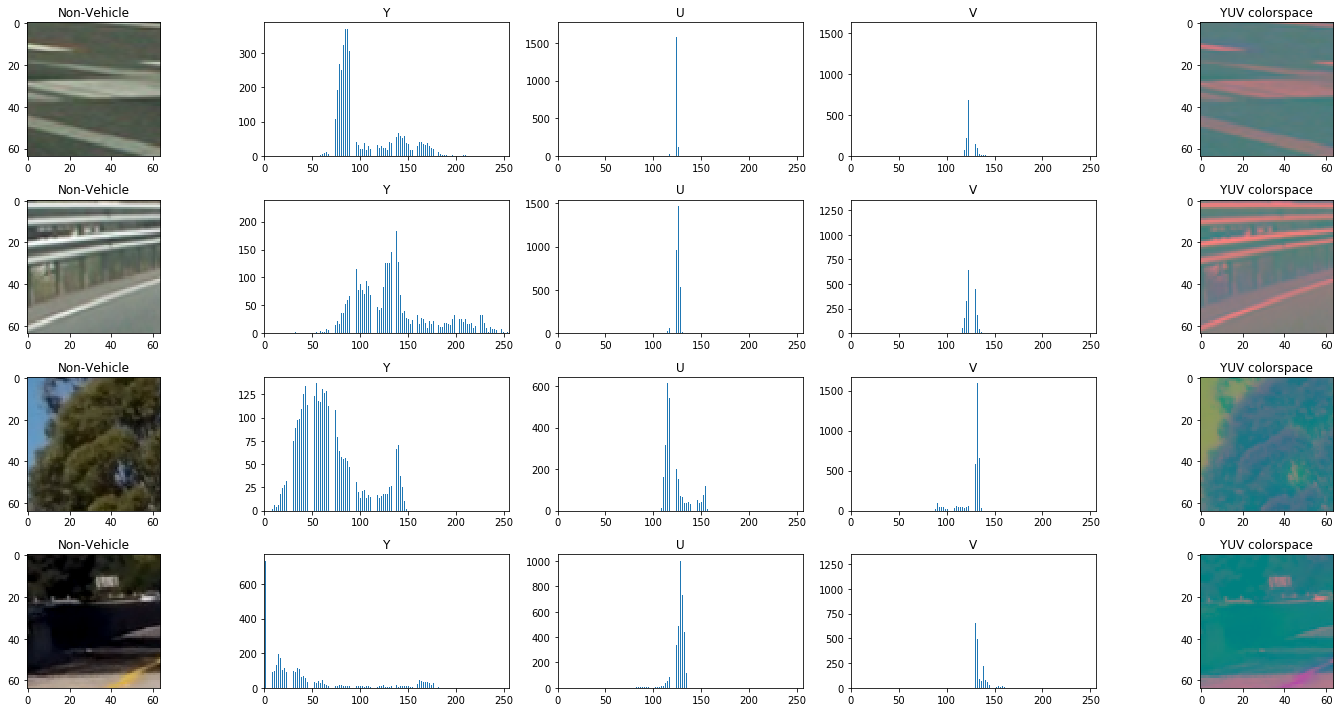

In [8]:
f, axes= plt.subplots(4,5, figsize=(20,10))
f.subplots_adjust(hspace=0.5)

for index in range(4):
        
    indx = random.randint(0, len(non_vehicle_image_names)-1)
    img = cv2.imread(non_vehicle_image_names[indx])
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    colored_image= cv2.cvtColor(rgb_img,cv2.COLOR_RGB2YUV)
    r,g,b = color_hist(colored_image, 128, color_feats=True)
   
    center= bin_center(r)
    axes[index,0].imshow(rgb_img)
    axes[index,0].set_title("Non-Vehicle")
    axes[index,1].set_xlim(0,256)
    axes[index,1].bar(center,r[0])
    axes[index,1].set_title("Y")
    axes[index,2].set_xlim(0,256)
    axes[index,2].bar(center,g[0])
    axes[index,2].set_title("U")
    axes[index,3].set_xlim(0,256)
    axes[index,3].bar(center,b[0])
    axes[index,3].set_title("V")
    axes[index,4].imshow(colored_image)
    axes[index,4].set_title("YUV colorspace")

save_fig("color_features_for_non_vehicle")
features = color_hist(colored_image)
print("Number of features of non-vehicle image:", len(features))

### Step 2.2: Spatial Binning

*Resizing Image to extract features, so as to reduce the feature vector size.*

*Define a function to excute spatial binning.*

In [9]:
def bin_spatial(img, size=(32,32)):
    features = np.concatenate([cv2.resize(img[:,:,i], size).ravel() for i in range(3)])
    return features

In [10]:
indx = random.randint(0, len(vehicle_images)-1)
img = vehicle_images[indx]
print("Number of features before spatial binning:", len(img.ravel()))
img_feat = bin_spatial(img)
print("Number of feature after spatial binning:", len(img_feat))

Number of features before spatial binning: 12288
Number of feature after spatial binning: 3072


### Step 2.3: HOG (Histogram of Oriented Gradients)

*General method to extract the HOG of the image.*

In [11]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    """Extract the HOG of the image."""
    # Call with two outputs if vis=True.
    if vis == True:
        hog_features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=False,
                                  visualize=vis, feature_vector=feature_vec)
        return hog_features, hog_image
    else:
        hog_features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=False,
                       visualize=vis, feature_vector=feature_vec)
        return hog_features

*Testing HOG on image.*

Saving figure hog_feature


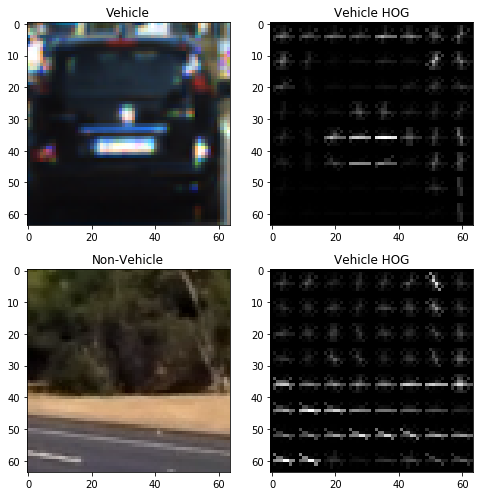

In [12]:
indx = random.randint(0, len(vehicle_images)-1)
vehicle_img = vehicle_images[indx]
_, vehicle_dst = get_hog_features(vehicle_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
non_vehicle_img = non_vehicle_images[indx]
_, non_vehicle_dst = get_hog_features(non_vehicle_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(vehicle_img)
ax1.set_title('Vehicle')
ax2.imshow(vehicle_dst, cmap='gray')
ax2.set_title('Vehicle HOG')
ax3.imshow(non_vehicle_img)
ax3.set_title('Non-Vehicle')
ax4.imshow(non_vehicle_dst, cmap='gray')
ax4.set_title('Vehicle HOG')
save_fig("hog_feature")

## Extract Features Data

Define a function to extract features from a list of image locations. This function could also be used to call `bin_spatial()` and `color_hist()` to extract flattened spatial color features and color histogram features and combine them all (making use of StandardScaler) to be used together for classification.

In [13]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=False, hist_feat=False, hog_feat=True):
    # Define an empty list to receive features
    features = []
    
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # Apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(img)
            
        # Compute spatial features if flag is set
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            # Append features to list
            features.append(spatial_features)
            
        # Compute histogram features if flag is set
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            # Append features to list
            features.append(hist_features)
            
        # Compute HOG features if flag is set
        if hog_feat == True:
    
            if hog_channel == 'ALL':
                hog_features = [get_hog_features(feature_image[:,:,channel], 
                                             orient, pix_per_cell, cell_per_block, 
                                             vis=False, feature_vec=True)
                            for channel in range(feature_image.shape[2])]
                hog_features = np.ravel(hog_features)
            
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append features to list
            features.append(hog_features)

    # Return array of features
    return features

*Let extract vehicle features and non-vehicle features.*

In [14]:
### Parameters
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

In [15]:
t = time.time()
print("Extracting vehicle features...")
vehicle_features = extract_features(vehicle_image_names, color_space=color_space,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block, hog_channel=hog_channel)
print("Vehicle features extracted!")
print()
print("Extracting non-vehicle features...")
non_vehicle_features = extract_features(non_vehicle_image_names, color_space=color_space,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block, hog_channel=hog_channel)
print("Non-Vehicle features extracted!")
t1 = time.time()
print("Extract HOG features take {:.0f} seconds".format(t1-t))
print()
print("Shape of vehicle features:", len(vehicle_features))
print("Shape of non-vehicle features:", len(non_vehicle_features))

Extracting vehicle features...
Vehicle features extracted!

Extracting non-vehicle features...
Non-Vehicle features extracted!
Extract HOG features take 128 seconds

Shape of vehicle features: 8792
Shape of non-vehicle features: 8968


*Combine features of both and create a vector contain label.*

In [16]:
X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))
print("Shape of features:", X.shape)
print("Shape of label:", y.shape)

Shape of features: (17760, 1188)
Shape of label: (17760,)


## Step 3: Data Processing 

### Step 3.1: Normalization and Scaling of Data

*Fit a per-column scaler - this will be necessary if combining different types of features (HOG + color_hist/bin_spatial).*

In [17]:
#scaler = StandardScaler()
# Fit a per-column scaler.
#X_scaler = scaler.fit(X)
# Apply the scaler to X.
#scaled_X = X_scaler.transform(X)

### Step 3.2: Splitting Data into Training and Test Set

In [18]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('Using:', orient, 'orientations', pix_per_cell,
    'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188


## Step 4: Train, Save and Load a classifier

### Step 4.1: Train a Linear SVM classifer.

In [19]:
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t1 = time.time()
print("Build Linear SVM classifier takes {:.0f} seconds".format(t1-t))
# Check the score of the SVC
print("Accuracy of SVC = {:.4f}%".format(svc.score(X_test, y_test)*100))

Build Linear SVM classifier takes 6 seconds
Accuracy of SVC = 97.8604%


### Step 4.2: Save classifier.

In [20]:
clf_pickle = {}
clf_pickle["svc"] = svc
clf_pickle["X"] = X
clf_pickle["orient"] = orient
clf_pickle["pix_per_cell"] = pix_per_cell
clf_pickle["cell_per_block"] = cell_per_block
clf_pickle["color_space"] = color_space

clf_path = 'clf_pickle_all_v1.p'
destnation = clf_path
pickle.dump(clf_pickle, open( destnation, "wb" ) )
print("Classifier is written into: {}".format(destnation))

Classifier is written into: clf_pickle_all_v1.p


### Step 4.3: Load classifier.

*If classifier exist.*

In [21]:
clf_path = 'clf_pickle_all_v1.p'

In [22]:
# if os.path.isfile(clf_path):
#     print('Loading existing classifier...')
#     with open(clf_path, 'rb') as file:
#         clf_pickle = pickle.load(file)
#         svc = clf_pickle["svc"]
#         X_scaler = clf_pickle["scaler"]
#         orient = clf_pickle["orient"]
#         pix_per_cell = clf_pickle["pix_per_cell"]
#         cell_per_block = clf_pickle["cell_per_block"]
#         spatial_size = clf_pickle["spatial_size"]
#         hist_bins = clf_pickle["hist_bins"]
#         color_space = clf_pickle["color_space"]

## Step 5: Detect Vehicles in an Image

### Step 5.1: Sliding Windows

*Define a single function that can extract features using hog sub-sampling and make predictions.*

In [23]:
def find_vehicles(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else:
        ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            ################ ONLY FOR BIN_SPATIAL AND COLOR_HIST ################

            # Extract the image patch
            #subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_prediction = svc.predict(test_features)
            
            ######################################################################
            
            hog_features = hog_features.reshape(1, -1) # delete this line if use BIN_SPATIAL AND COLOR_HIST.
            
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

*Test `find_vehicles` on test image.*

In [24]:
# Set parameters.
ystart = 400
ystop = 656
scale = 1.5
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

Number of rectangles is vehicle found in image: 4


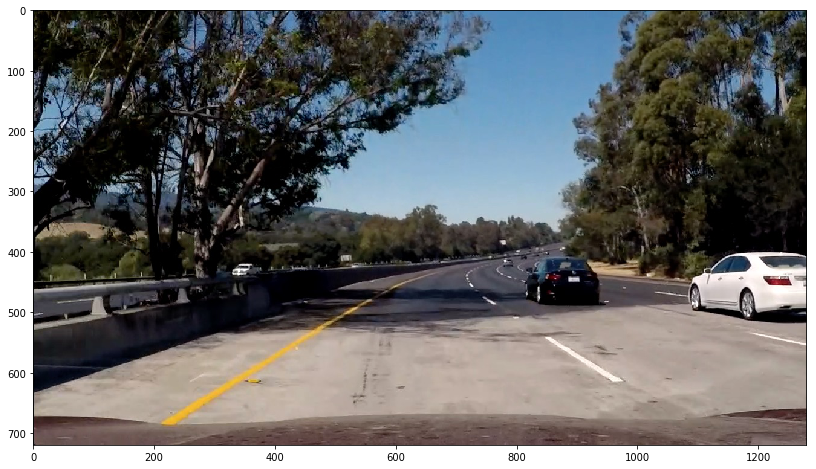

In [25]:
test_img = mpimg.imread('images/test_images/test5.jpg')

plt.figure(figsize=(15,8))
plt.imshow(test_img)

rectangles = find_vehicles(test_img, ystart, ystop, scale, color_space, hog_channel,
                       svc, None, orient, pix_per_cell, cell_per_block, None, None)


print("Number of rectangles is vehicle found in image:", len(rectangles))

*Show test image.*

### Step 5.2: Draw Sliding Windows

*Function to draw sliding Windows.*

In [26]:
def draw_boxes(img, bboxes, color=(0,0,255), thick=6):
    # Make a copy of the image.
    imcopy = np.copy(img)
    
    # Iterate through the bounding boxes.
    for bbox in bboxes:
        # Draw in a rectangle  given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

*Draw the rectangles onto the example image.*

Saving figure raw_rectangles


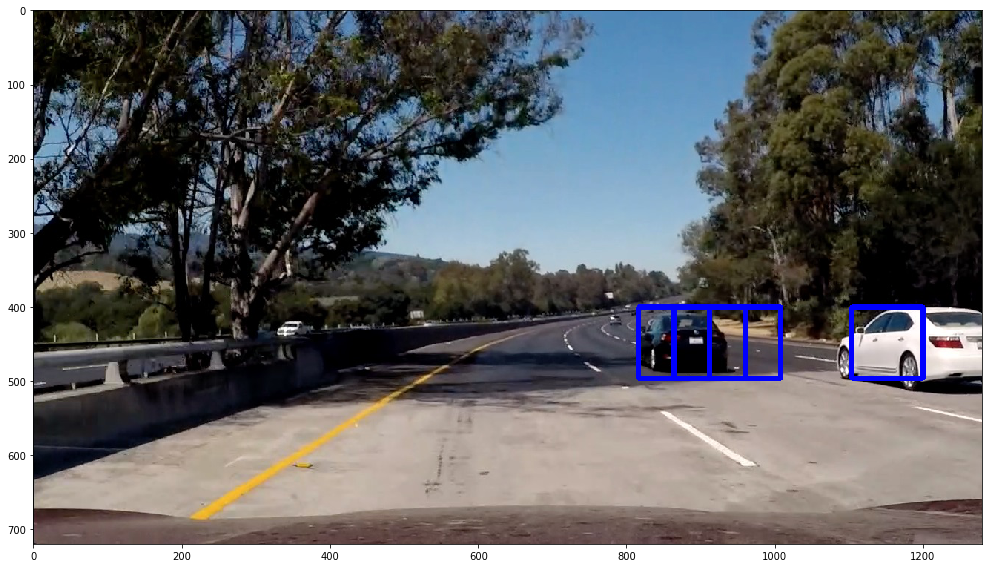

In [27]:
test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(15,8))
plt.imshow(test_img_rects)
save_fig("raw_rectangles")

**Show All Potential Search Areas**

Because the size and position of cars in the image will be different depending on their distance from the camera, `find_vehicles` will have to be called a few times with different `ystart`, `ystop`, and `scale` values. These next few blocks of code are for determining the values for these parameters that work best.

Saving figure draw_all_rectangles1
Number of boxes:  39


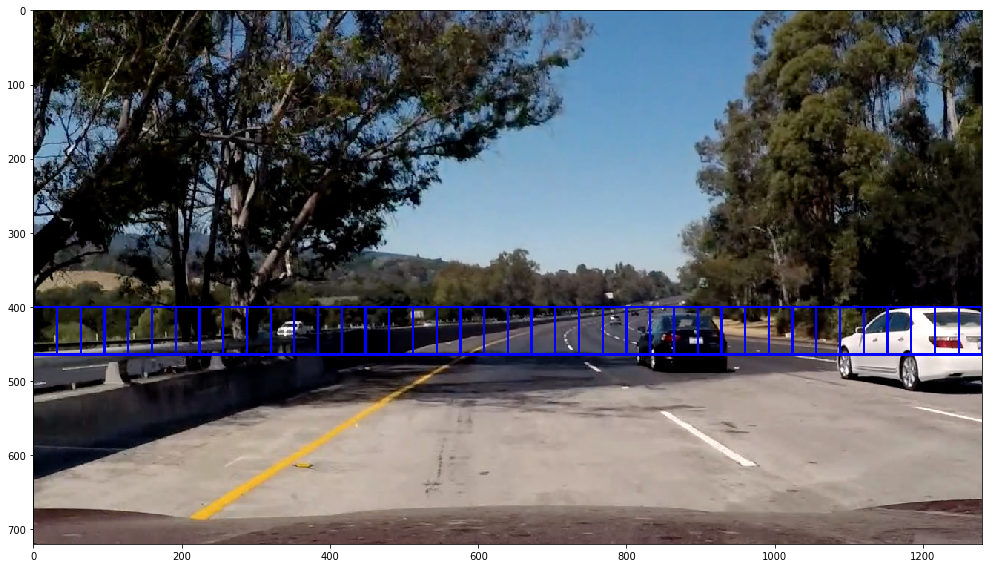

In [28]:
test_img = mpimg.imread('images/test_images/test5.jpg')

rects = []

ystart = 400
ystop = 464
scale = 1.0
rects.append(find_vehicles(test_img, ystart, ystop, scale, color_space, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, thick=2)
plt.figure(figsize=(15,8))
plt.imshow(test_img_rects)
save_fig("draw_all_rectangles1")
print('Number of boxes: ', len(rectangles))

Saving figure draw_all_rectangles2
Number of boxes:  50


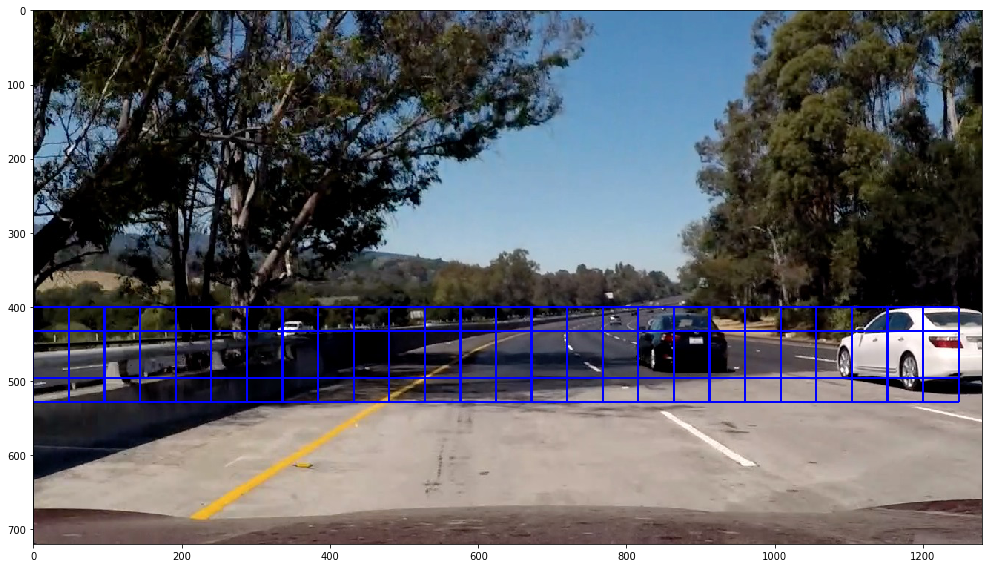

In [29]:
rects = []

ystart = 400
ystop = 496
scale = 1.5
rects.append(find_vehicles(test_img, ystart, ystop, scale, color_space, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
ystart = 432
ystop = 528
scale = 1.5
rects.append(find_vehicles(test_img, ystart, ystop, scale, color_space, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, thick=2)
plt.figure(figsize=(15,8))
plt.imshow(test_img_rects)
save_fig("draw_all_rectangles2")
print('Number of boxes: ', len(rectangles))

Saving figure draw_all_rectangles3
Number of boxes:  24


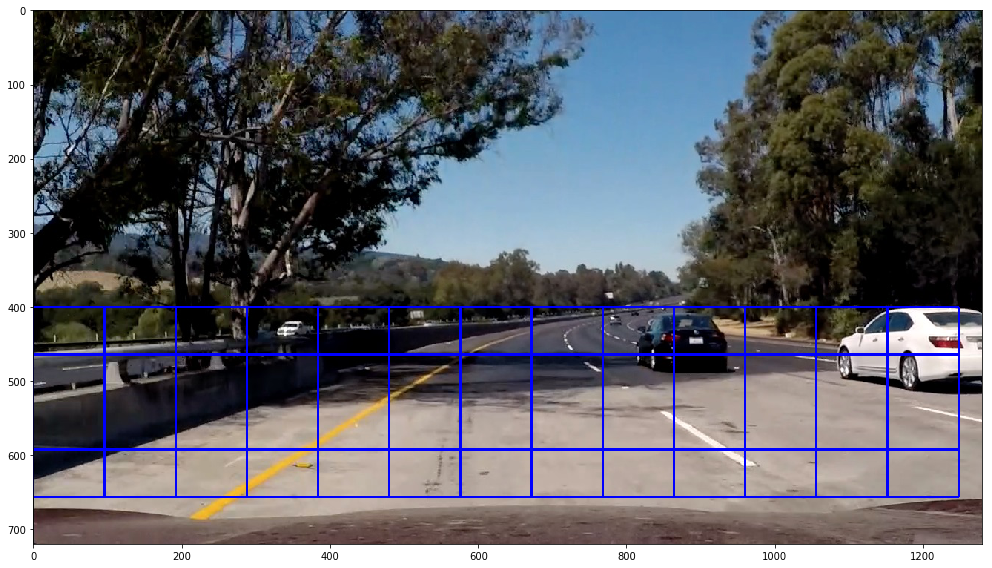

In [30]:
rects = []

ystart = 400
ystop = 596
scale = 3.0
rects.append(find_vehicles(test_img, ystart, ystop, scale, color_space, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
ystart = 464
ystop = 660
scale = 3.0
rects.append(find_vehicles(test_img, ystart, ystop, scale, color_space, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, thick=2)
plt.figure(figsize=(15,8))
plt.imshow(test_img_rects)
save_fig("draw_all_rectangles3")
print('Number of boxes: ', len(rectangles))

### Step 5.3: Combine Various Sliding Window Searches

Saving figure sliding_window


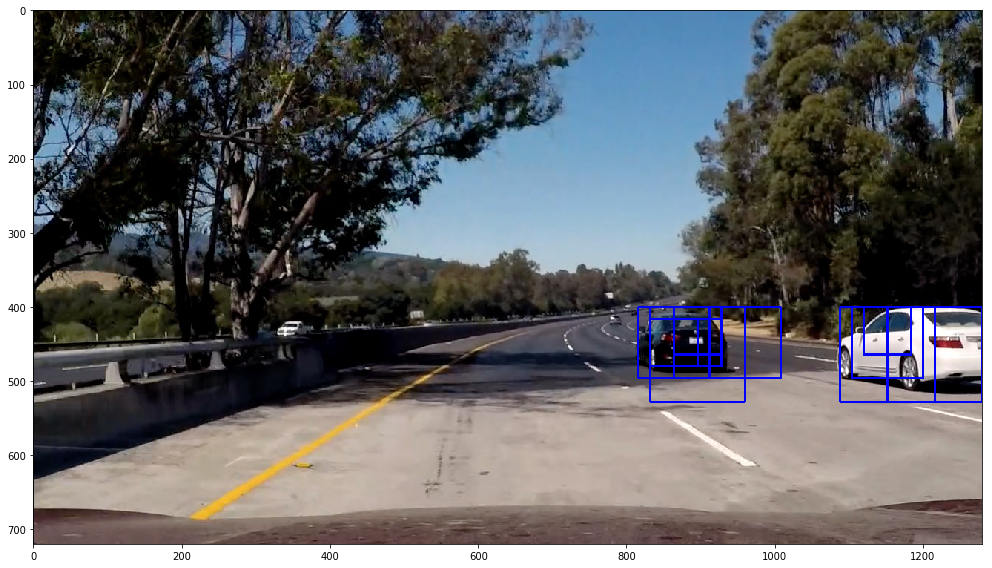

In [31]:
test_img = mpimg.imread('images/test_images/test5.jpg')

rectangles = []

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"


ystart = 400
ystop = 464
scale = 1.0
rectangles.append(find_vehicles(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 416
ystop = 480
scale = 1.0
rectangles.append(find_vehicles(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 400
ystop = 496
scale = 1.5
rectangles.append(find_vehicles(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 432
ystop = 528
scale = 1.5
rectangles.append(find_vehicles(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 400
ystop = 528
scale = 2.0
rectangles.append(find_vehicles(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 432
ystop = 560
scale = 2.0
rectangles.append(find_vehicles(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 400
ystop = 596
scale = 3.5
rectangles.append(find_vehicles(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 464
ystop = 660
scale = 3.5
rectangles.append(find_vehicles(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))

# apparently this is the best way to flatten a list of lists
rectangles = [item for sublist in rectangles for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, thick=2)
plt.figure(figsize=(15,8))
plt.imshow(test_img_rects)
save_fig("sliding_window")

*Exploration findings:* 
- A scale of less than 1.0 seemed to produce a lot of false positives. 
- The start and stop positions and scales used may need some tweaking in the future, depending on video performance.

## Step 6: Heatmap

### Step 6.1: Heatmap basics

*This method produces a heat map based on rectangle locations (additive with overlap).*

In [32]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes.
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox.
        # Assuming each "box" takes the form ((x1, y1), (x2, y2)).
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
    # Return updated heatmap.
    return heatmap

*Test out the heatmap.*

Saving figure heatmap


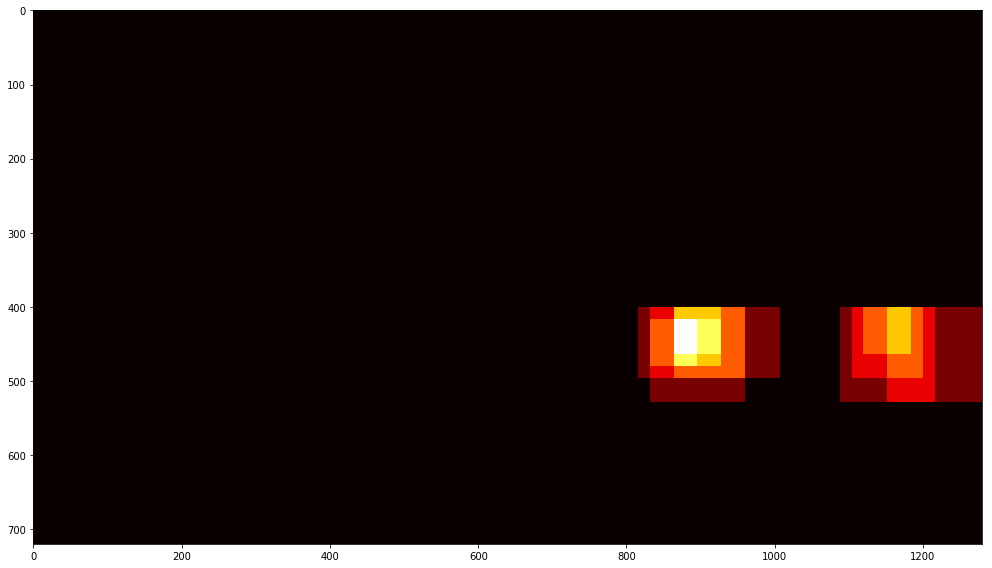

In [33]:
heatmap_img = np.zeros_like(test_img[:, :, 0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(15,8))
plt.imshow(heatmap_img, cmap='hot')
save_fig("heatmap")

### Step 6.2: Heatmap with threshold

In [34]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

*Test out a threshold(=1) to the Heatmap.*

Saving figure heat_map_with_threshold


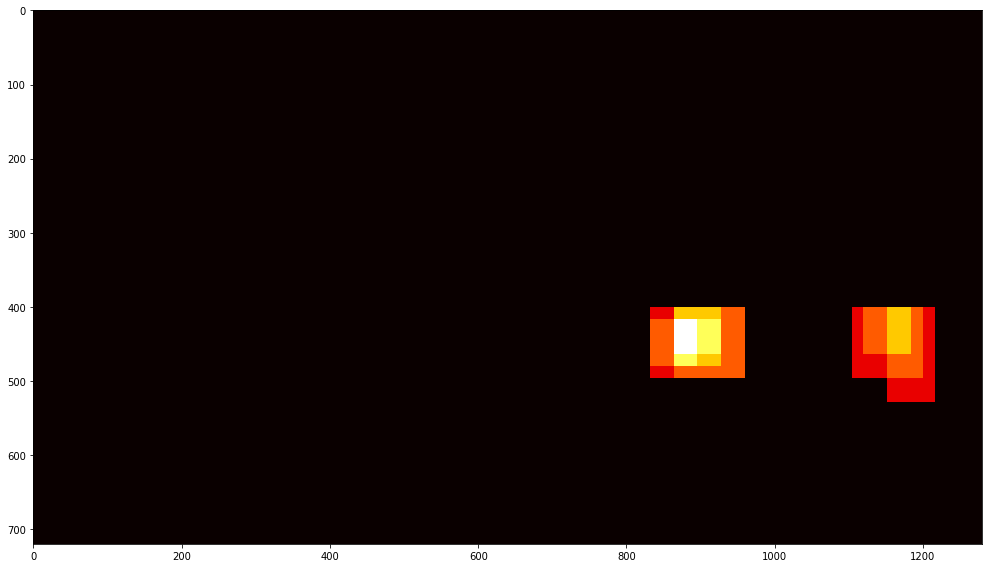

In [35]:
heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(15,8))
plt.imshow(heatmap_img, cmap='hot')
save_fig("heat_map_with_threshold")

### Step 6.3: Apply SciPy Labels to Heatmap

2 vehicles found
Saving figure heatmat_with_labels


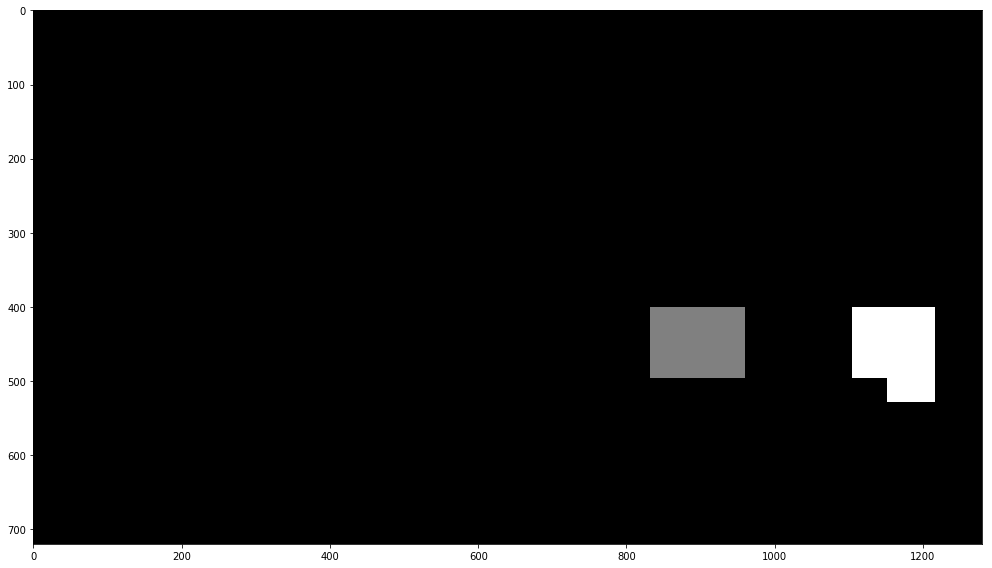

In [36]:
labels = label(heatmap_img)
plt.figure(figsize=(15,8))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'vehicles found')
save_fig("heatmat_with_labels")

### Step 6.4: Draw Bounding Boxes for Lables

In [37]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

Saving figure draw_boxes_for_labels


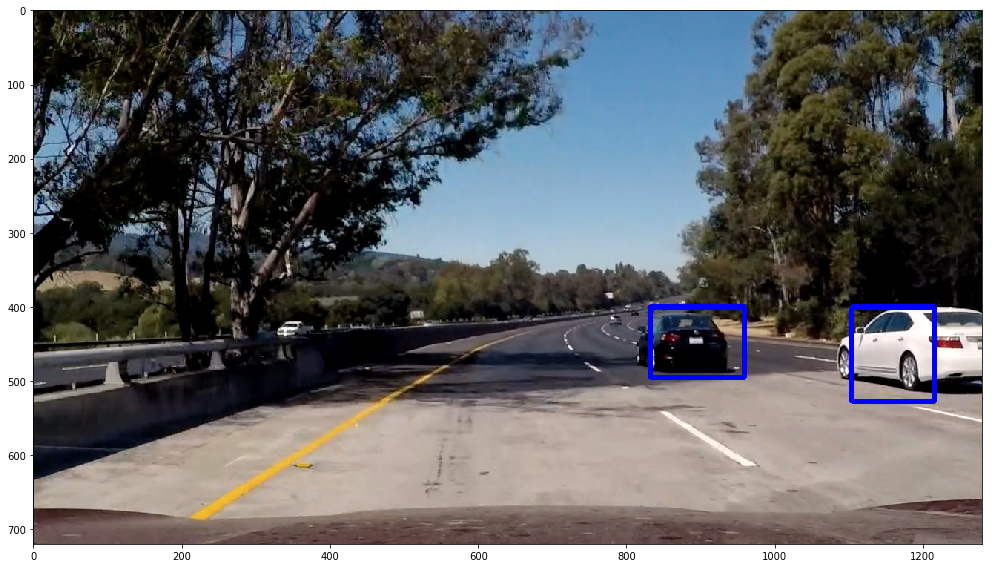

In [38]:
# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(15,8))
plt.imshow(draw_img)
save_fig("draw_boxes_for_labels")

### Put it All Together

In [39]:
def process_frame(img):

    rectangles = []

    color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_vehicles(img, ystart, ystop, scale, color_space, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_vehicles(img, ystart, ystop, scale, color_space, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_vehicles(img, ystart, ystop, scale, color_space, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_vehicles(img, ystart, ystop, scale, color_space, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_vehicles(img, ystart, ystop, scale, color_space, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_vehicles(img, ystart, ystop, scale, color_space, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(find_vehicles(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_vehicles(img, ystart, ystop, scale, color_space, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    rectangles = [item for sublist in rectangles for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

## Step 7: Vehicle detect on Image

Saving figure vehicl_detect_on_image


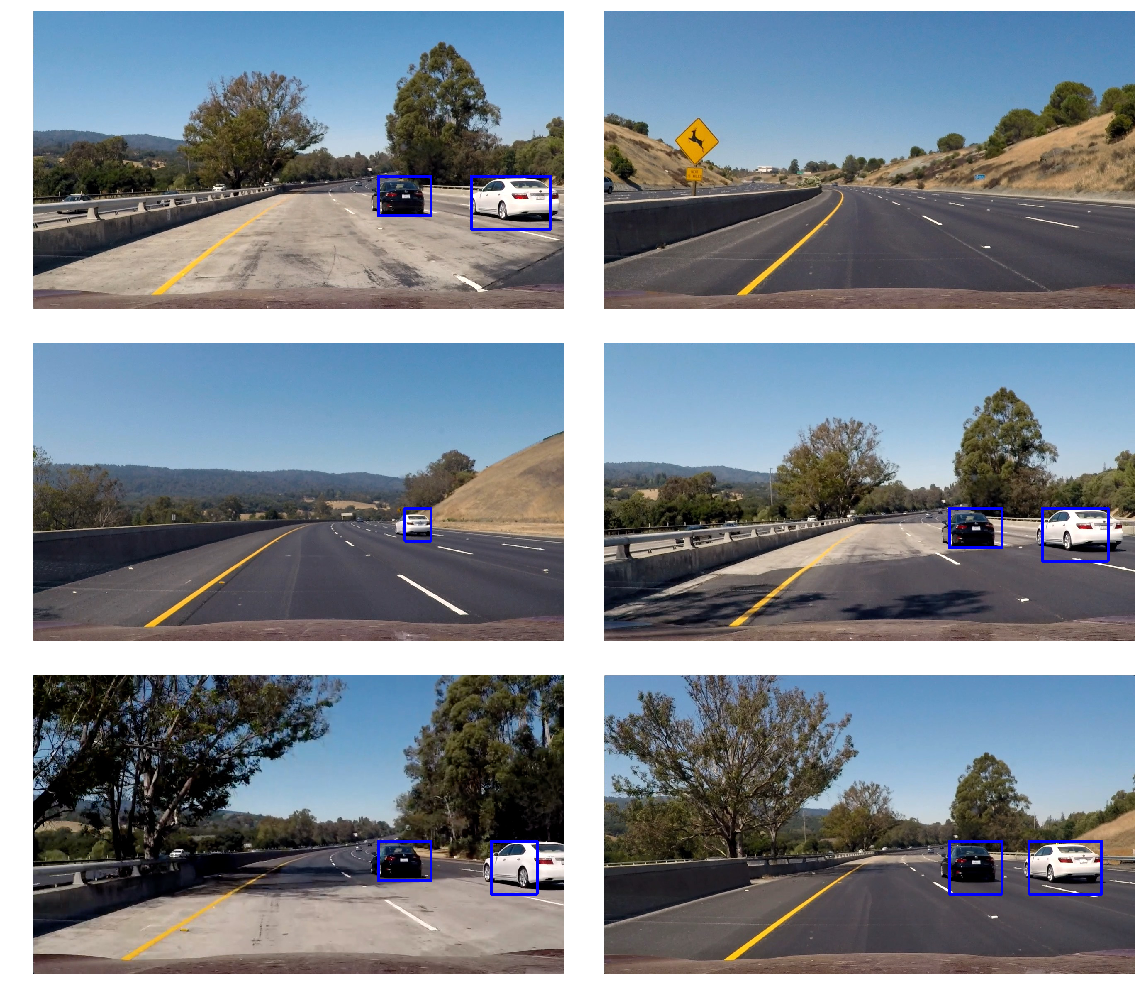

In [40]:
test_images = glob.glob('images/test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_frame(mpimg.imread(im)))
    axs[i].axis('off')
save_fig("vehicl_detect_on_image")

## Step 8: Vehicle detect on Video

### Run a Video Through the Pipeline (primitive version)
This only processes a frame at a time without accounting for information from previous frames.

In [41]:
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|████████████████████████████████████████▉ | 38/39 [00:27<00:00,  1.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Wall time: 32.6 s


In [42]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

### Run a Video Through the Pipeline (advanced version)
This processes each frame while accounting for information from previous frames

*Define a Class to Store Data from Vehicle Detections.*

In [43]:
# Define a class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

**Pipeline for Processing Video Frames.**

In [44]:
def process_frame_for_video(img):

    rectangles = []

    color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_vehicles(img, ystart, ystop, scale, color_space, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_vehicles(img, ystart, ystop, scale, color_space, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_vehicles(img, ystart, ystop, scale, color_space, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_vehicles(img, ystart, ystop, scale, color_space, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_vehicles(img, ystart, ystop, scale, color_space, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_vehicles(img, ystart, ystop, scale, color_space, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(find_vehicles(img, ystart, ystop, scale, color_space, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_vehicles(img, ystart, ystop, scale, color_space, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
 
    rectangles = [item for sublist in rectangles for item in sublist] 
    
    # add detections to the history
    if len(rectangles) > 0:
        det.add_rects(rectangles)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    heatmap_img = apply_threshold(heatmap_img, 1 + len(det.prev_rects)//2)
     
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

*Run on video have length approximately 1 second.*

In [45]:
det = Vehicle_Detect()

test_out_file2 = 'test_video_out_2.mp4'
clip_test2 = VideoFileClip('test_video.mp4')
clip_test_out2 = clip_test2.fl_image(process_frame_for_video)
%time clip_test_out2.write_videofile(test_out_file2, audio=False)

[MoviePy] >>>> Building video test_video_out_2.mp4
[MoviePy] Writing video test_video_out_2.mp4


 97%|████████████████████████████████████████▉ | 38/39 [00:28<00:00,  1.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out_2.mp4 

Wall time: 32.5 s


In [46]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file2))

*Test on video have length 50 seconds.*

In [47]:
det = Vehicle_Detect()

proj_out_file = 'project_video_out.mp4'
clip_proj = VideoFileClip('project_video.mp4') #.subclip(23,26)  # subclip = only specified span of video
#clip_proj.save_frame('./test_images/project1.jpg', t=1.0) # saves the frame at time = t seconds
clip_proj_out = clip_proj.fl_image(process_frame_for_video)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████▉| 1260/1261 [15:43<00:00,  1.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 15min 47s


In [48]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(proj_out_file))

## Some Tips and Tricks
+ If you are stuck with long processing time while running pipeline on video, please try reducing windows first.
+ If you are still stuck with long processing time try reducing the number of features extracted.
+ If you have a test set of say 10,000 images and your feature size is 8000, SVM will not perform upto the mark even if the accuracy on the test set is above 95%. Use SVM with ‘rbf’ kernel or reduce features.
+ If it still takes long time for the pipeline to run, try skipping one half or two thirds of the frames. It will speed up. Remember by skipping frames I mean skipping the processing of frames and setting the refined windows of that frame to rectangles gathered from previous 15 frames stored in some data structure.